<a href="https://colab.research.google.com/github/svhenrique/FireSmokeTCC/blob/main/TCCFireSmoke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detector de Fogo e Fumaça por Visão Computacional 

* O objetivo é criar um modelo de Visão Computacional eficiente capaz de classificar fogo ou fumaça em um ambiente.
* [Dataset de fogo e fumaça](https://www.kaggle.com/datasets/dataclusterlabs/fire-and-smoke-dataset?resource=download)

Pesquisas:
* https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2
* https://www.kaggle.com/code/delllectron/fire-detection-computer-vision
* https://towardsdatascience.com/data-augmentation-techniques-in-python-f216ef5eed69
* https://meatba11.medium.com/keras-loading-and-processing-images-in-batches-1cff1b0f4aa4
* https://pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
* https://www.kaggle.com/code/wadjihbencheikh/fire-prediction
* https://github.com/pedbrgs/Fire-Detection
* https://bigmms.github.io/cheng_gcce19_smoke100k/
* TPOT (AutoML, solta melhor modelo)
- Referencial Teórico
	- conceitos de VC
	- TPOT AutoML
	- Métricas de avaliação 
		F1SCORE
		ACURÁCIA
		RECALL
		ETC
	

## Preparando ambiente 

In [1]:
# Lendo drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# bibliotecas necessárias
from google.colab.patches import cv2_imshow 
import os
from matplotlib import pyplot as plt
from glob import glob
import numpy as np
!pip install --upgrade opencv-python
import cv2
import pandas as pd

from sklearn.model_selection import train_test_split
import sklearn.metrics

from keras.utils.np_utils import to_categorical 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications.mobilenet_v3 import MobileNetV3
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.densenet import DenseNet201
from keras.applications.efficientnet_v2 import EfficientNetV2L 
from keras.applications.convnext import ConvNeXtXLarge
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import decode_predictions
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.layers import Dense
from keras import Model

!pip install tpot
# from tpot import TPOTClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# dados em pasta 
data_folder = '/content/drive/MyDrive/Estudos/UFAL/TCC/dataset2/'

## Preparando variáveis globais de treino e teste

In [4]:
# declarando path de imagens de treino 
path_train = {
    "fire": os.path.join(data_folder, "train", "fire"),
    "smoke": os.path.join(data_folder, "train", "smoke"),
    "normal": os.path.join(data_folder, "train", "normal"),
}

In [5]:
# declarando path de imagens de teste 
path_test = {
    "fire": os.path.join(data_folder, "test", "fire"),
    "smoke": os.path.join(data_folder, "test", "smoke"),
    "normal": os.path.join(data_folder, "test", "normal"),
}

## Análise

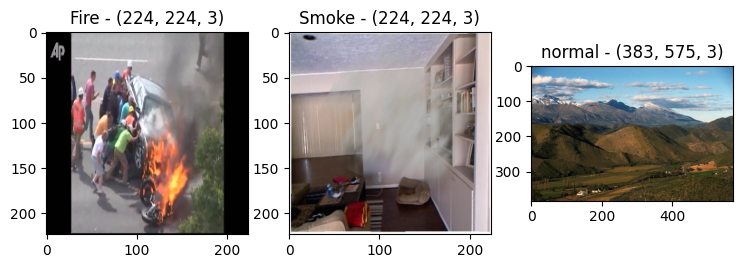

In [6]:
# lendo imagens de drive

# criando figure
fig = plt.figure(figsize=(12, 12))
fig.tight_layout()
rows, columns = 1, 4

# adicionando subplot na primeira posição
fig.add_subplot(rows, columns, 1)
img1 =  cv2.cvtColor(cv2.imread(
    os.path.join(path_train["fire"], os.listdir(path_train["fire"])[0])),
    cv2.COLOR_BGR2RGB
)
plt.imshow(img1)
plt.title(f"Fire - {img1.shape}")
  
# adicionando subplot na segunda posição
fig.add_subplot(rows, columns, 2)
img2 = cv2.cvtColor(cv2.imread(
    os.path.join(path_train["smoke"], os.listdir(path_train["smoke"])[0])),
    cv2.COLOR_BGR2RGB
)
plt.imshow(img2)
plt.title(f"Smoke - {img2.shape}")

# adicionando subplot na terceira posição
fig.add_subplot(rows, columns, 3)
img3 = cv2.cvtColor(cv2.imread(
    os.path.join(path_train["normal"], os.listdir(path_train["normal"])[0])),
    cv2.COLOR_BGR2RGB
)
plt.imshow(img3)
plt.title(f"normal - {img3.shape}")

plt.show()

* Diferentes tamanhos de imagem
  * Transformação dos dados para padronização será necessária 
* Existem 3 tipos de imagem:
  * Fire: imagens de fogo 
  * Smoke: imagens de fumaça 
  * norma: imagens que não contem fogo e nem fumaça

In [7]:
# quantas imagens tem no dataset de treino
for path in path_train:
  folder = path_train[path]
  print(f"{path}: {len(os.listdir(folder))}")

fire: 2218
smoke: 2218
normal: 2218


Talvez seja necessário usar algum método de crescimento de dados para que o modelo consiga abstrair melhor as classes.

In [8]:
# quantas imagens tem no dataset de teste
for path in path_train:
  folder = path_test[path]
  print(f"{path}: {len(os.listdir(folder))}")

fire: 1000
smoke: 1000
normal: 1000


## Criando função de pré-processamento para modelo

In [9]:
"""Algoritmo - (imagem):
  setar tamanho fixo de imagem com constantes
  transformar com operações de opencv imagem (se necessário)
  multiplicar imagem com movimentações
  retornar array com imagens 
  """

IMAGE_W = 224
IMAGE_H = 224

def pre_processing(img):
  images = []
  img = cv2.resize(img, [IMAGE_W, IMAGE_H])
  images.append(cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE))
  images.append(cv2.rotate(img, cv2.ROTATE_180))
  images.append(cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))
  return [array/255 for array in images]

## Criando dataframe de imagens 

In [10]:
def make_df(classes, path_data, size=(224, 224)):
  data = []
  for _class in classes:
    path = path_data[_class]
    for file in os.listdir(path):
      # data.append([os.path.join(path, file), classes[_class]]) # add path
      img = cv2.imread(os.path.join(path, file)) 
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (size[0], size[1]))
      img = np.asarray(img)
      data.append([img, classes[_class]])
  df =  pd.DataFrame(data, columns=['file', 'class'])
  return df

def make_df(classes, path_data, size):
  data = []
  X = []
  y = []
  for _class in classes:
    path = path_data[_class]
    for file in os.listdir(path):
      # data.append([os.path.join(path, file), classes[_class]]) # add path
      img = cv2.imread(os.path.join(path, file))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (size[0], size[1]))
      img = np.asarray(img)/255
      X.append(img)
      y.append(classes[_class])
  return np.array(X), np.array(y)

In [11]:
# declarando variável de classes 
classes = {
    "fire": np.array([1, 0, 0]), 
    "smoke": np.array([0, 1, 0]), 
    "normal": np.array([0, 0, 1]), 
}

## Treinando e testando modelos

In [12]:
MODELS_FOLDER = os.path.join(data_folder, "Models")
def get_or_train_model(model, X, y):
  class_name = model.__name__
  model_path = os.path.join(MODELS_FOLDER, class_name)
  if class_name in os.listdir(MODELS_FOLDER):
    my_model = tf.keras.models.load_model(model_path)
  else:
    model_loaded = model(weights='imagenet')
    my_model = transfom_model(model_loaded)
    # compilando modelo
    my_model.compile(
        optimizer='adam',
        loss="categorical_crossentropy", #loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
        run_eagerly=True
    )
    # treinando modelo
    my_model.fit(x=X, y=y, epochs=50, verbose=2)
    # salvando modelo
    my_model.save(model_path)
  print(my_model.summary())
  return my_model


In [13]:
def transfom_model(model):
  output = Dense(3, activation='softmax')
  output = output(model.layers[-2].output)
  model_result = Model(model.input, outputs=output)
  return model_result

In [14]:
# https://www.kaggle.com/code/kmkarakaya/multi-label-model-evaluation
LABELS = list(classes.keys())
def predict_and_get_statistics(model, y):
  result = model.predict(X_test)
  result_max = np.argmax(result, axis=1)
  y_max = np.argmax(y_test, axis=1)
  print(sklearn.metrics.classification_report(result_max, y_max, target_names=LABELS))
  return sklearn.metrics.classification_report(result_max, y_max, target_names=LABELS, output_dict=True)

### MobileNetV2

In [ ]:
# criando dataframe de treino pandas para análise e processamento de dados size 224
size = (224, 224)
df_train = make_df(classes, path_train, size=size)
X_train, y_train = df_train[0], df_train[1]
del df_train
df_test = make_df(classes, path_test, size=size)
X_test, y_test = df_test[0], df_test[1]
del df_test

In [ ]:
# MobileNetV2 
my_mobv2 = get_or_train_model(MobileNetV2, X_train, y_train)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [22]:
# prevendo e pegando estatísticas 
my_mobv2_sts = predict_and_get_statistics(my_mobv2, y_test)

94/94 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

        fire       0.98      0.83      0.90      1186
       smoke       0.85      0.99      0.92       860
      normal       0.94      0.98      0.96       954

    accuracy                           0.92      3000
   macro avg       0.92      0.93      0.92      3000
weighted avg       0.93      0.92      0.92      3000



In [ ]:
# limpando dados
del X_train
del y_train
del X_test
del y_test

### ResNet152V2

In [ ]:
# criando dataframe de treino pandas para análise e processamento de dados size 224
size = (224, 224)
df_train = make_df(classes, path_train, size=size)
X_train, y_train = df_train[0], df_train[1]
del df_train
df_test = make_df(classes, path_test, size=size)
X_test, y_test = df_test[0], df_test[1]
del df_test

In [ ]:
# ResNet152V2 
my_resv2 = get_or_train_model(ResNet152V2, X_train, y_train)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# prevendo e pegando estatísticas 
my_resv2_sts = predict_and_get_statistics(my_resv2, y_test)

In [ ]:
# limpando dados
del X_train
del y_train
del X_test
del y_test

### DenseNet201

In [15]:
# criando dataframe de treino pandas para análise e processamento de dados size 224
size = (224, 224)
df_train = make_df(classes, path_train, size=size)
X_train, y_train = df_train[0], df_train[1]
del df_train
df_test = make_df(classes, path_test, size=size)
X_test, y_test = df_test[0], df_test[1]
del df_test

In [16]:
# DenseNet201 
my_dense201 = get_or_train_model(DenseNet201, X_train, y_train)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [19]:
# prevendo e pegando estatísticas 
my_dense201_sts = predict_and_get_statistics(my_dense201, y_test)

94/94 [==============================] - 13s 30ms/step
              precision    recall  f1-score   support

        fire       0.97      0.91      0.94      1066
       smoke       0.89      0.99      0.94       901
      normal       0.95      0.92      0.94      1033

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



In [ ]:
# limpando dados
del X_train
del y_train
del X_test
del y_test

### EfficientNetV2L

In [15]:
# criando dataframe de treino pandas para análise e processamento de dados size 224
size = (480, 480)
df_train = make_df(classes, path_train, size=size)
X_train, y_train = df_train[0], df_train[1]
del df_train

In [ ]:
# EfficientNetV2L 
my_efficient_v2l = get_or_train_model(EfficientNetV2L, X_train, y_train)

In [ ]:
# prevendo e pegando estatísticas 
del X_train
del y_train
df_test = make_df(classes, path_test, size=size)
X_test, y_test = df_test[0], df_test[1]
del df_test
my_efficient_v2l_sts = predict_and_get_statistics(my_efficient_v2l, y_test)

In [20]:
# limpando dados
del X_train
del y_train
del X_test
del y_test

### ConvNeXtXLarge 

In [ ]:
# criando dataframe de treino pandas para análise e processamento de dados size 224
size = (224, 224)
df_train = make_df(classes, path_train, size=size)
X_train, y_train = df_train[0], df_train[1]
del df_train
df_test = make_df(classes, path_test, size=size)
X_test, y_test = df_test[0], df_test[1]
del df_test

In [ ]:
# ConvNeXtXLarge 
my_convnextxtxlarge = get_or_train_model(ConvNeXtXLarge, X_train, y_train)

In [ ]:
# prevendo e pegando estatísticas 
my_convnextxtxlarge_sts = predict_and_get_statistics(my_convnextxtxlarge, y_test)

In [ ]:
# limpando dados
del X_train
del y_train
del X_test
del y_test